## Problem Statement

At some point or the other almost each one of us has used an Ola or Uber for taking a ride. 

Ride hailing services are services that use online-enabled platforms to connect between passengers and local drivers using their personal vehicles. In most cases they are a comfortable method for door-to-door transport. Usually they are cheaper than using licensed taxicabs. Examples of ride hailing services include Uber and Lyft.

<img src="2560px-Ride_hailing_services_Wikivoyage_banner.jpg">

To improve the efficiency of taxi dispatching systems for such services, it is important to be able to predict how long a driver will have his taxi occupied. If a dispatcher knew approximately when a taxi driver would be ending their current ride, they would be better able to identify which driver to assign to each pickup request.

In this competition, we are challenged to build a model that predicts the total ride duration of taxi trips in New York City.

## 1. Exploratory Data Analysis
Let's check the data files! According to the data description we should find the following columns:

 - **id** - a unique identifier for each trip
 - **vendor_id** - a code indicating the provider associated with the trip record
 - **pickup_datetime** - date and time when the meter was engaged
 - **dropoff_datetime** - date and time when the meter was disengaged
 - **passenger_count** - the number of passengers in the vehicle (driver entered value)
 - **pickup_longitude** - the longitude where the meter was engaged
 - **pickup_latitude** - the latitude where the meter was engaged
 - **dropoff_longitude** - the longitude where the meter was disengaged
 - **dropoff_latitude** - the latitude where the meter was disengaged
 - **store_and_fwd_flag** - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server (Y=store and forward; N=not a store and forward trip)
 - **trip_duration** - (target) duration of the trip in seconds

Here, we have 2 variables dropoff_datetime and store_and_fwd_flag which are not available before the trip starts and hence will not be used as features to the model.

### 1.1 Load Libraries

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from datetime import timedelta
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

In [2]:
#pip install seaborn==0.9.0

The error "AttributeError:module'seaborn' has no attribute 'tsplot'" appears. That is why I have downgraded my Seaborn version. We verified that seaborn==0.9.0 is compatible with the tsplot function. As a result, we can downgrade it to version seaborn==0.9.0. 

### Load Data

In [3]:
data = pd.read_csv('EDA_NYC_Taxi (1).zip')

In [4]:
df = data.sample(n = 500, random_state=1)

In [5]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
455488,id2898909,1,2016-03-03 10:30:21,2016-03-03 10:43:49,1,-73.991409,40.750320,-73.978813,40.762032,N,808
112922,id3276089,2,2016-03-23 18:39:57,2016-03-23 19:01:06,1,-73.981850,40.773289,-73.978973,40.757240,N,1269
713928,id2303543,2,2016-03-03 11:34:33,2016-03-03 11:56:03,1,-73.873032,40.774055,-73.744003,40.776676,N,1290
287988,id0955609,2,2016-05-23 21:02:17,2016-05-23 21:13:37,1,-73.968178,40.762280,-73.970680,40.788422,N,680
29862,id0548011,2,2016-01-19 10:18:47,2016-01-19 10:27:54,3,-74.017197,40.705070,-74.007240,40.722599,N,547


In [6]:
df.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,1.542000,1.624000,-73.969287,40.749679,-73.970195,40.753214,870.884000
std,0.498732,1.251302,0.045889,0.030782,0.040690,0.034650,724.606564
min,1.000000,1.000000,-74.017197,40.641727,-74.176933,40.614029,75.000000
25%,1.000000,1.000000,-73.991320,40.737894,-73.990116,40.738467,379.250000
50%,2.000000,1.000000,-73.981056,40.755484,-73.978340,40.756550,658.500000
75%,2.000000,2.000000,-73.967798,40.767414,-73.960070,40.773083,1137.750000
max,2.000000,6.000000,-73.776688,40.821224,-73.744003,40.920628,5967.000000


### File structure and content

In [7]:
print('We have {} rows.'.format(df.shape[0]))
print('We have {} columns'.format(df.shape[1]))
df.iloc[1,:]

We have 500 rows.
We have 11 columns


id                              id3276089
vendor_id                               2
pickup_datetime       2016-03-23 18:39:57
dropoff_datetime      2016-03-23 19:01:06
passenger_count                         1
pickup_longitude                -73.98185
pickup_latitude                 40.773289
dropoff_longitude              -73.978973
dropoff_latitude                 40.75724
store_and_fwd_flag                      N
trip_duration                        1269
Name: 112922, dtype: object

At first glance, we can see the types of each variable and what they look like. 

### Missing Values
Knowing about missing values is important because they indicate how much we don’t know about our data. Making inferences based on just a few cases is often unwise. In addition, many modelling procedures break down when missing values are involved and the corresponding rows will either have to be removed completely or the values need to be estimated somehow.

In [8]:
np.sum(pd.isnull(df))

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

Fortunately, in this dataset we do not have any missing values which is great.

### Reformatting features & Checking consistency
There are a variety of features within the dataset and it is important to convert them into the right format such that we can analyse them easily. This would include converting datetime features and string features. 

Also, one important thing is never to take assumptions without backing it with data. Here, as you can see the trip duration can also be calculated pick up and drop off datetime. We will check whether the given duration is consistent with the calculated trip duration 

In [9]:
# converting strings to datetime features
df['pickup_datetime'] = pd.to_datetime(df.pickup_datetime)
df['dropoff_datetime'] = pd.to_datetime(df.dropoff_datetime)

# Converting yes/no flag to 1 and 0
df['store_and_fwd_flag'] = 1 * (df.store_and_fwd_flag.values == 'Y')

df['check_trip_duration'] = (df['dropoff_datetime'] - df['pickup_datetime']).map(lambda x: x.total_seconds())

duration_difference = df[np.abs(df['check_trip_duration'].values  - df['trip_duration'].values) > 1]
duration_difference.shape

(0, 12)

This implies that there is no inconsistency in data wrt the drop location and trip duration

### Target Exploration
In this section we will take a look at the trip duration which is the target variable. It is crucial to understand it in detail as this is what we are trying to predict accurately.

In [10]:
df['trip_duration'].describe()/3600 # Trip duration in hours

count    0.138889
mean     0.241912
std      0.201280
min      0.020833
25%      0.105347
50%      0.182917
75%      0.316042
max      1.657500
Name: trip_duration, dtype: float64

Woah! There is a trip with duration of 979 hours. This is a huge outlier and might create problems at the prediction stage. One idea is to log transform the trip duration before prediction to visualise it better.

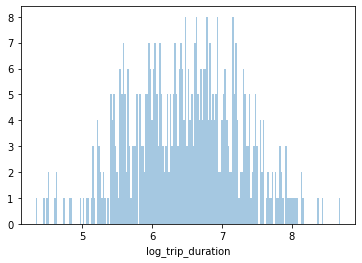

In [11]:
df['log_trip_duration'] = np.log(df['trip_duration'].values + 1)
sns.distplot(df['log_trip_duration'], kde = False, bins = 200)
plt.show()

We find:

1. The majority of rides follow a rather smooth distribution that looks almost log-normal with a peak just around exp(6.5)  i.e. about 17 minutes.
2. There are several suspiciously short rides with less than 10 seconds duration.
3. As discussed earlier, there are a few huge outliers near 12.

### Univariate Visualization
First of all, let us look at some of the binary features. Looking at each feature might uncover some insight that might be useful at later modelling stages

Text(0, 0.5, 'Frequency')

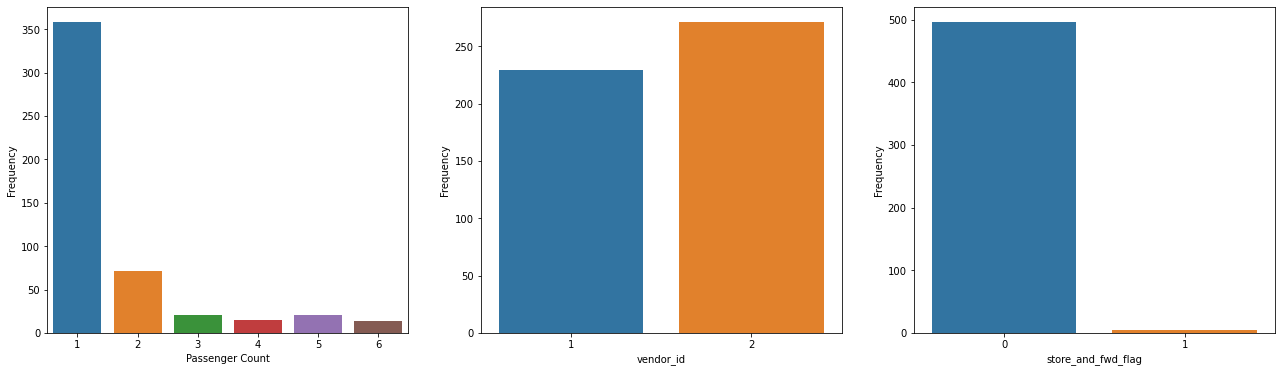

In [12]:
# Binary Features
plt.figure(figsize=(22, 6))
#fig, axs = plt.subplot(ncols=2)

# Passenger Count
plt.subplot(131)
sns.countplot(df['passenger_count'])
plt.xlabel('Passenger Count')
plt.ylabel('Frequency')


# vendor_id
plt.subplot(132)
sns.countplot(df['vendor_id'])
plt.xlabel('vendor_id')
plt.ylabel('Frequency')

# store_and_fwd_flag
plt.subplot(133)
sns.countplot(df['store_and_fwd_flag'])
plt.xlabel('store_and_fwd_flag')
plt.ylabel('Frequency')


Observations:
1. Most of the trips involve only 1 passenger. There are trips with 7-9 passengers but they are very low in number.
2. Vendor 2 has more number of trips as compared to vendor 1
3. The store_and_fwd_flag values, indicating whether the trip data was sent immediately to the vendor (“0”) or held in the memory of the taxi because there was no connection to the server (“1”), show that there was almost no storing taking place

Now, we will delve into the datetime features to understand the trend of number of hourly/monthly/daily taxi trips 

In [13]:
df['pickup_datetime'].min(), df['pickup_datetime'].max()

(Timestamp('2016-01-01 01:11:01'), Timestamp('2016-06-28 23:25:07'))

Clearly, These trips are for first 6 months of 2016. To look at trends, we first need to extract week days and hour of day from the pickup date.

In [14]:
df['day_of_week'] = df['pickup_datetime'].dt.weekday
df['hour_of_day'] = df['pickup_datetime'].dt.hour

Text(0, 0.5, 'Total number of pickups')

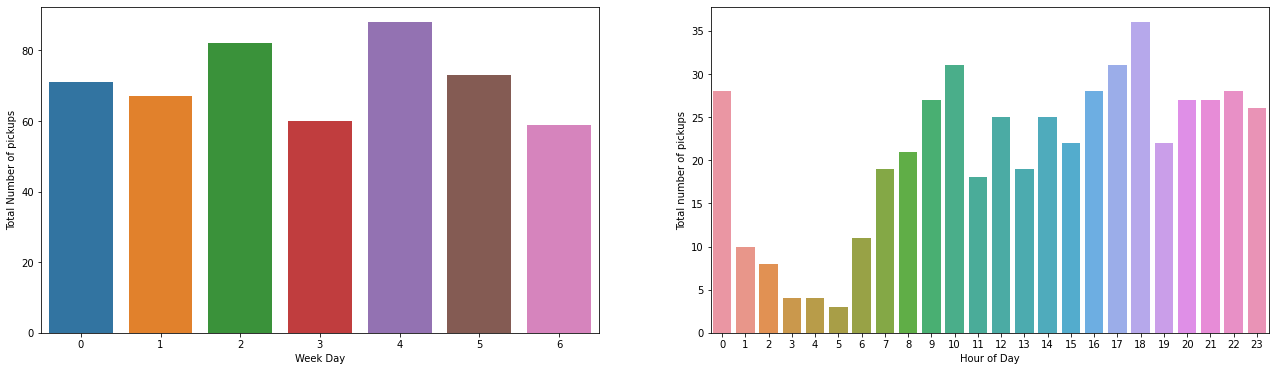

In [15]:

# Datetime features
plt.figure(figsize=(22, 6))

# Passenger Count
plt.subplot(121)
sns.countplot(df['day_of_week'])
plt.xlabel('Week Day')
plt.ylabel('Total Number of pickups')

# vendor_id
plt.subplot(122)
sns.countplot(df['hour_of_day'])
plt.xlabel('Hour of Day')
plt.ylabel('Total number of pickups')


* Number of pickups for weekends is much lower than week days with a peak on Thursday (4). Note that here weekday is a decimal number, where 0 is Sunday and 6 is Saturday.
* Number of pickups as expected is highest in late evenings. However, it is much lower during the morning peak hours.

### Lattitude & Longitude

Lets look at the geospatial or location features to check consistency. They should not vary much as we are only considering trips within New York city.

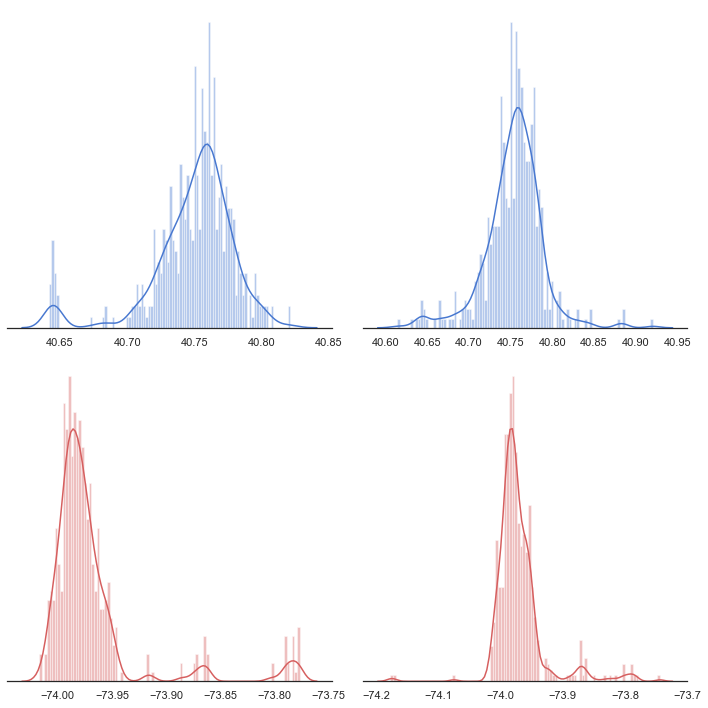

In [16]:
sns.set(style="white", palette="muted", color_codes=True)
f, axes = plt.subplots(2,2,figsize=(10, 10), sharex=False, sharey = False)
sns.despine(left=True)
sns.distplot(df['pickup_latitude'].values, label = 'pickup_latitude',color="b",bins = 100, ax=axes[0,0])
sns.distplot(df['pickup_longitude'].values, label = 'pickup_longitude',color="r",bins =100, ax=axes[1,0])
sns.distplot(df['dropoff_latitude'].values, label = 'dropoff_latitude',color="b",bins =100, ax=axes[0,1])
sns.distplot(df['dropoff_longitude'].values, label = 'dropoff_longitude',color="r",bins =100, ax=axes[1,1])
plt.setp(axes, yticks=[])
plt.tight_layout()
plt.show()

Findings - (Here, red represents pickup and dropoff Longitudes & blue represents pickup & dropoff lattitudes)

1. From the plot above it is clear that pick and drop latitude are centered around 40 to 41, and longitude are situated around -74 to -73. 
2. Some extreme co-ordinates has squeezed the plot such that we see a spike here
3. A good idea is to remove these outliers and look at the distribution more closely

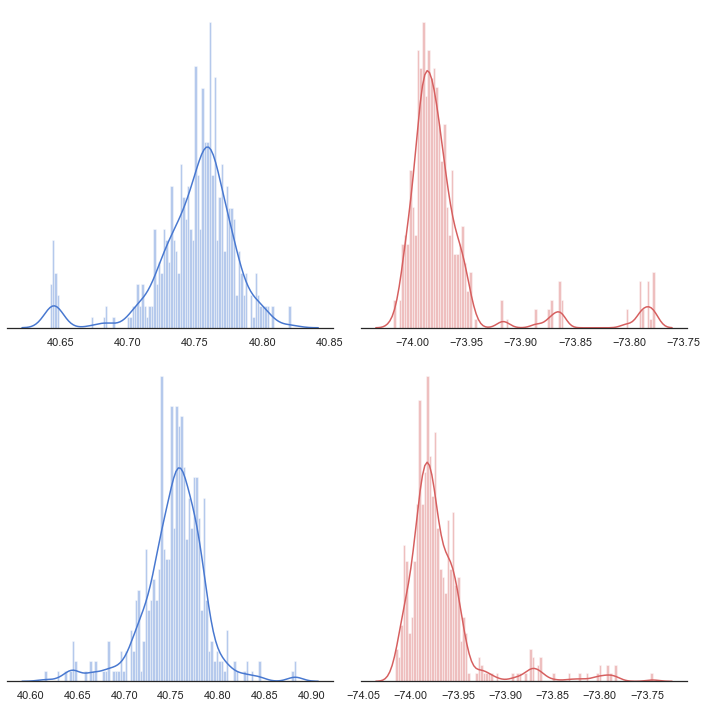

In [17]:
df = df.loc[(df.pickup_latitude > 40.6) & (df.pickup_latitude < 40.9)]
df = df.loc[(df.dropoff_latitude>40.6) & (df.dropoff_latitude < 40.9)]
df = df.loc[(df.dropoff_longitude > -74.05) & (df.dropoff_longitude < -73.7)]
df = df.loc[(df.pickup_longitude > -74.05) & (df.pickup_longitude < -73.7)]
df_data_new = df.copy()
sns.set(style="white", palette="muted", color_codes=True)
f, axes = plt.subplots(2,2,figsize=(10, 10), sharex=False, sharey = False)#
sns.despine(left=True)
sns.distplot(df_data_new['pickup_latitude'].values, label = 'pickup_latitude',color="b",bins = 100, ax=axes[0,0])
sns.distplot(df_data_new['pickup_longitude'].values, label = 'pickup_longitude',color="r",bins =100, ax=axes[0,1])
sns.distplot(df_data_new['dropoff_latitude'].values, label = 'dropoff_latitude',color="b",bins =100, ax=axes[1, 0])
sns.distplot(df_data_new['dropoff_longitude'].values, label = 'dropoff_longitude',color="r",bins =100, ax=axes[1, 1])
plt.setp(axes, yticks=[])
plt.tight_layout()

plt.show()

* We have a much better view of the distribution of coordinates instead of spikes. And we see that most trips are concentrated between these lat long only with a few significant clusters.
* These clusters are represented by the numerous peaks in the lattitude and longitude histograms


### Bivariate Relations with Target
Now that we have gone through all the basic features one by one. Let us start looking at their relation with the target. This will help us in selecting and extracting features at the modelling stage.

In [18]:
df.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'check_trip_duration', 'log_trip_duration',
       'day_of_week', 'hour_of_day'],
      dtype='object')

### Trip Duration vs Weekday

For different week days, the trip durations can vary as different week days might have different traffic densities especially the weekends might have a much different patterns as compared to working days. Weekday is taken as a decimal number, where 0 - Sunday and 6 is Saturday.

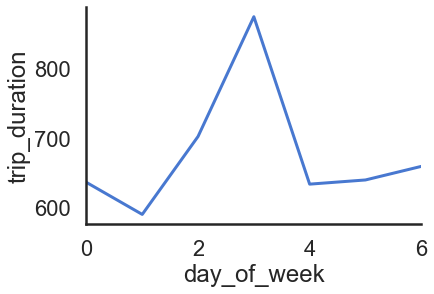

In [19]:
summary_wdays_avg_duration = pd.DataFrame(df.groupby(['day_of_week'])['trip_duration'].median())
summary_wdays_avg_duration.reset_index(inplace = True)
summary_wdays_avg_duration['unit']=1

sns.set(style="white", palette="muted", color_codes=True)
sns.set_context("poster")
sns.tsplot(data=summary_wdays_avg_duration, time="day_of_week", unit = "unit", value="trip_duration")
sns.despine(bottom = False)

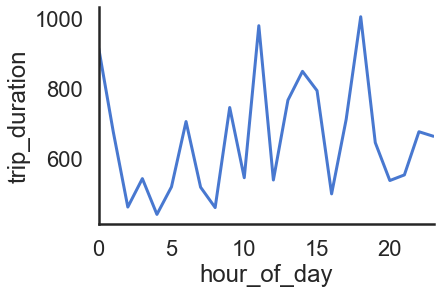

In [20]:

summary_hourly_avg_duration = pd.DataFrame(df.groupby(['hour_of_day'])['trip_duration'].median())
summary_hourly_avg_duration.reset_index(inplace = True)
summary_hourly_avg_duration['unit']=1

sns.set(style="white", palette="muted", color_codes=True)
sns.set_context("poster")
sns.tsplot(data=summary_hourly_avg_duration, time="hour_of_day", unit = "unit", value="trip_duration")
sns.despine(bottom = False)



* Trip durations are definitely shorter for late night and early morning hours that can be attributed to low traffic density
* It follows a similar pattern when compared to number of pickups indicating a correlation between number of pickups and trip duration

### vendor_id vs Trip Duration

Let's check how the trip duration varies for different vendors.

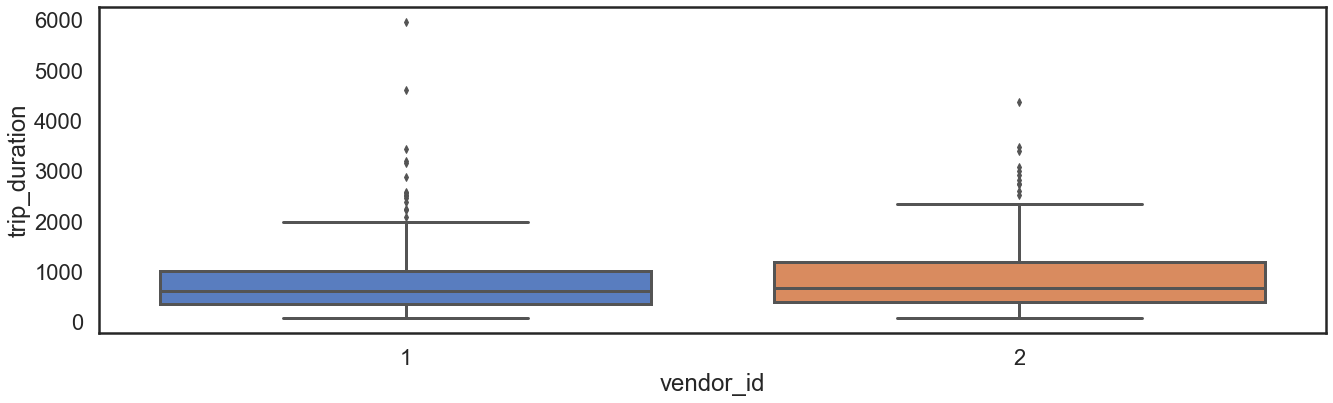

In [21]:
plt.figure(figsize=(22, 6))
sns.boxplot(x="vendor_id", y="trip_duration", data=df)
plt.show()

Woah! This did not came out as expected. The only thing I can see from this boxplot is that for vendor 2, there are a number of outliers exceeding 24 hours while vendor 1 does not have such long trips.

There could be 2 solutions to this:
1. Remove the huge outliers and plot again 
2. Look at median trip duration for both vendors on hourly basis

Let's try the first technique now and check trips below 50000 seconds only

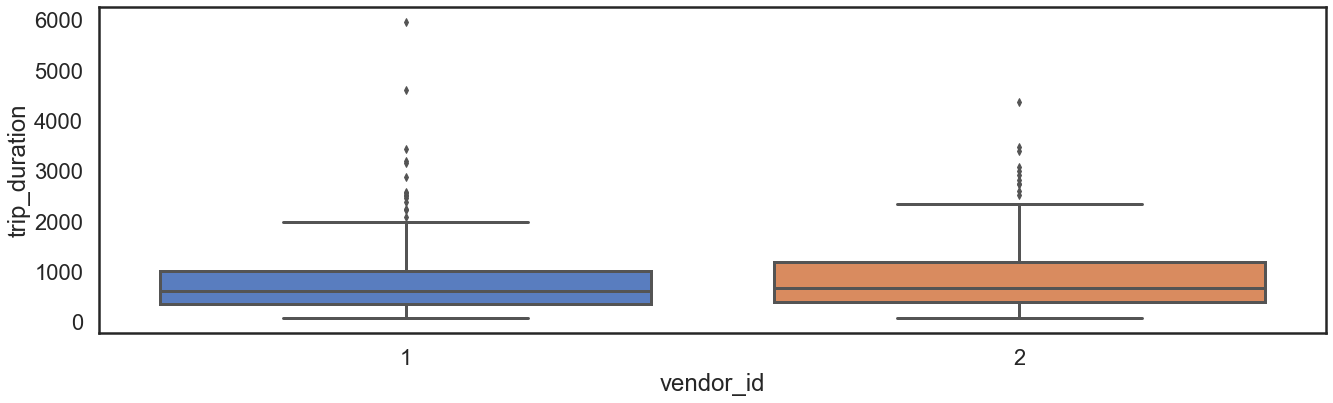

In [22]:
plt.figure(figsize=(22, 6))
df_sub = df[df['trip_duration'] < 50000]
sns.boxplot(x="vendor_id", y="trip_duration", data=df_sub)
plt.show()

As you can see, we were in a false perception earlier that vendor 1 had more outliers. Since the median is just around 600 seconds, we observe that vendor 2 has many more outliers as compared to vendor 1. Next, to confirm this, we will quickly look at the mean wrt day of week for both vendors using tsplot (time series plot) from seaborn.

### Mean Trip Duration Vendor Wise

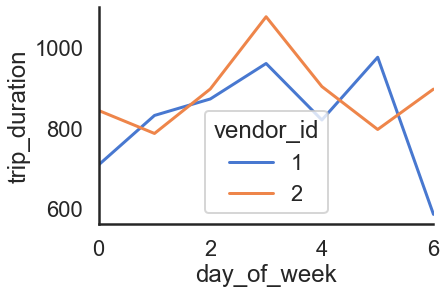

In [23]:
summary_wdays_avg_duration = pd.DataFrame(df.groupby(['vendor_id','day_of_week'])['trip_duration'].mean())
summary_wdays_avg_duration.reset_index(inplace = True)
summary_wdays_avg_duration['unit']=1

sns.set(style="white", palette="muted", color_codes=True)
sns.set_context("poster")
sns.tsplot(data=summary_wdays_avg_duration, time="day_of_week", unit = "unit", condition="vendor_id", value="trip_duration")
sns.despine(bottom = False)



### Median Trip Duration Vendor Wise

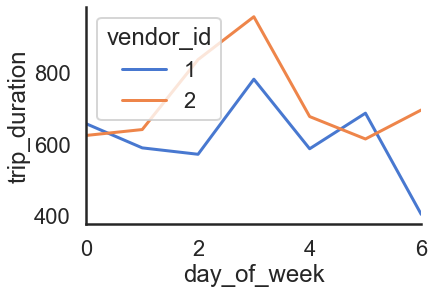

In [24]:
summary_wdays_avg_duration = pd.DataFrame(df.groupby(['vendor_id','day_of_week'])['trip_duration'].median())
summary_wdays_avg_duration.reset_index(inplace = True)
summary_wdays_avg_duration['unit']=1

sns.set(style="white", palette="muted", color_codes=True)
sns.set_context("poster")
sns.tsplot(data=summary_wdays_avg_duration, time="day_of_week", unit = "unit", condition="vendor_id", value="trip_duration")
sns.despine(bottom = False)



Median trip duration does not vary much as can be seen from the above plot for different vendors. It emphasises the importance of looking at the correct measure for central tendency for analysis.

### Trip Duration vs Passenger Count

Again as we are aware, there are a large number of outliers for trip duration and we will not be able to observe the differences. For this, we have taken a cutoff of 10000 seconds and used a boxplot.

In [25]:
df.passenger_count.value_counts()

1    356
2     70
3     21
5     21
4     15
6     14
Name: passenger_count, dtype: int64

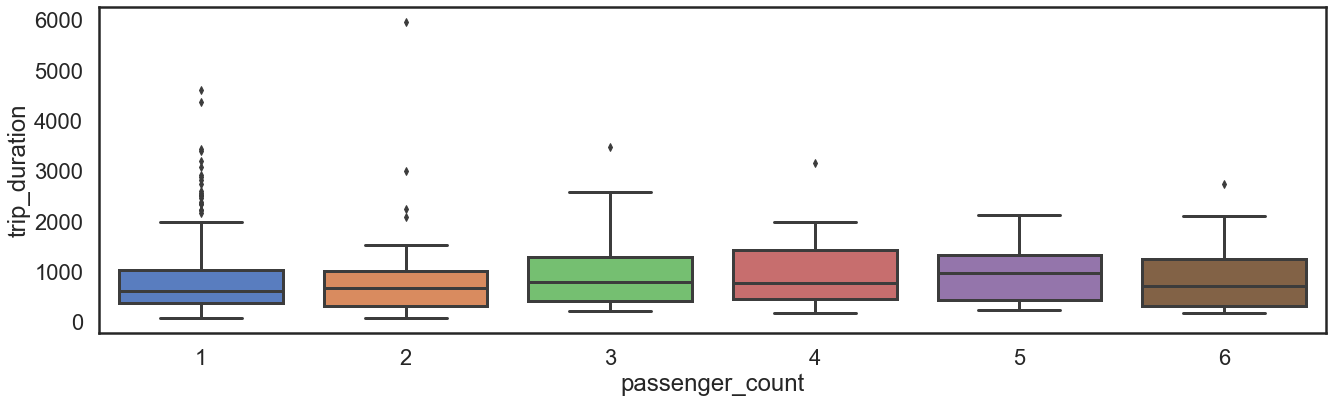

In [26]:
df.passenger_count.value_counts()
plt.figure(figsize=(22, 6))
df_sub = df[df['trip_duration'] < 10000]
sns.boxplot(x="passenger_count", y="trip_duration", data=df_sub)
plt.show()



* The boxplot clearly shows that there not much of a difference in distribution for the most frequently occuring passenger count values - 1, 2, 3.
* Another key observation is that the number of outliers are reduced for higher passenger counts but that only comes down to the individual frequencies of each passenger count.

### Visualise most frequently occuring Pickup points on the lattitude-longitude Map

Here, we try to visualise the most frequently occuring pickup points on the map and check how it is distributed spatially.

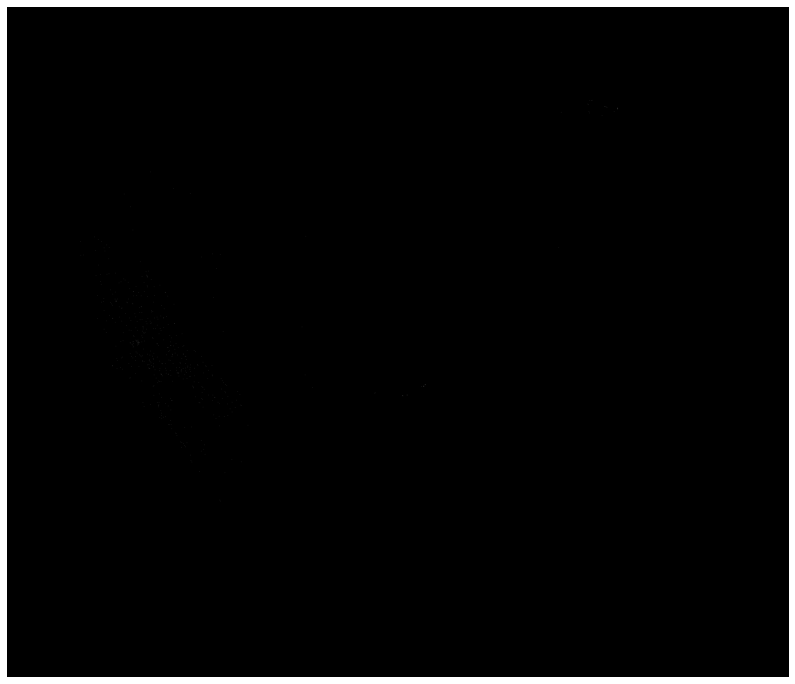

In [27]:

rgb = np.zeros((3000, 3500, 3), dtype=np.uint8)
rgb[..., 0] = 0
rgb[..., 1] = 0
rgb[..., 2] = 0
df_data_new['pick_lat_new'] = list(map(int, (df['pickup_latitude'] - (40.6000))*10000))
df_data_new['drop_lat_new'] = list(map(int, (df['dropoff_latitude'] - (40.6000))*10000))
df_data_new['pick_lon_new'] = list(map(int, (df['pickup_longitude'] - (-74.050))*10000))
df_data_new['drop_lon_new'] = list(map(int,(df['dropoff_longitude'] - (-74.050))*10000))

summary_plot = pd.DataFrame(df_data_new.groupby(['pick_lat_new', 'pick_lon_new'])['id'].count())

summary_plot.reset_index(inplace = True)
summary_plot.head(120)
lat_list = summary_plot['pick_lat_new'].unique()
for i in lat_list:
    lon_list = summary_plot.loc[summary_plot['pick_lat_new']==i]['pick_lon_new'].tolist()
    unit = summary_plot.loc[summary_plot['pick_lat_new']==i]['id'].tolist()
    for j in lon_list:
        a = unit[lon_list.index(j)]
        if (a//25) >0:
            rgb[i][j][0] = 255
            rgb[i,j, 1] = 0
            rgb[i,j, 2] = 0
        elif (a//10)>0:
            rgb[i,j, 0] = 0
            rgb[i,j, 1] = 255
            rgb[i,j, 2] = 0
        else:
            rgb[i,j, 0] = 255
            rgb[i,j, 1] = 255
            rgb[i,j, 2] = 255
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(14,20))
ax.imshow(rgb, cmap = 'hot')
ax.set_axis_off() 

Findings - From the heatmap kind of image above -

* White points - 1-10 trips have white as pickup point
* Green points - 10-25 trips have green as pickup point
* Red points - More than 25 trips have red as pickup point

As expected there are a few small clusters for hot pickup points as displayed by red in the above plot. Most pickup points have less than 10 trips and distributed all over the city.

If you go and have a look at an actual map of New York City, red and green points are mostly concentrated around the Manhatten Area

### Correlation Heatmap

Let us quickly look at the correlation heatmap to check the correlations amongst all features.

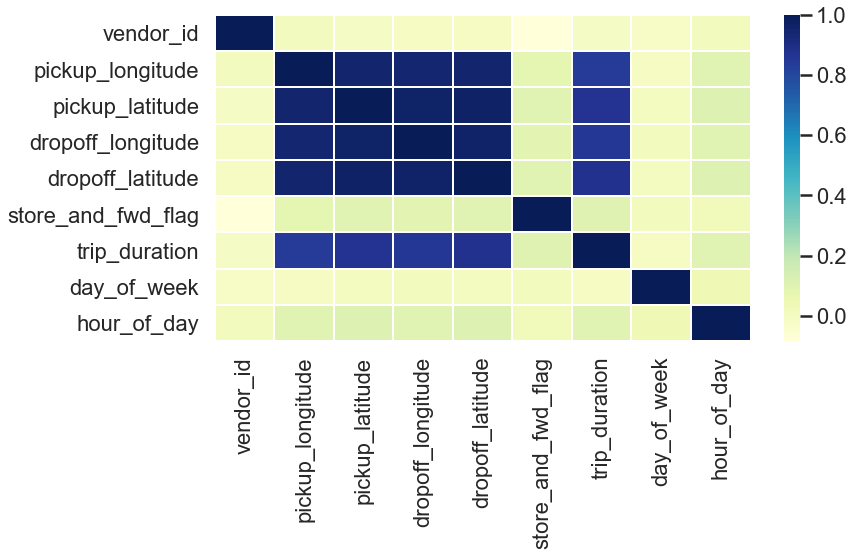

In [28]:
plt.figure(figsize=(12, 6))
df = df.drop(['id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count','check_trip_duration','log_trip_duration'],
        axis=1)
corr = df.apply(lambda x: pd.factorize(x)[0]).corr()
ax = sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, 
                 linewidths=.2, cmap="YlGnBu")

# Segregating variables: Independent and Dependent Variables

In [29]:
#seperating independent and dependent variables
x = df.drop(['trip_duration'], axis=1)
y = df['trip_duration']
x.shape, y.shape

((497, 8), (497,))

# Scaling the data (Using MinMax Scaler)

The original distribution's shape is preserved by MinMaxScaler. It has no effect on the information included in the original data. It should be noted that MinMaxScaler does not lessen the significance of outliers. The feature returned by MinMaxScaler has a default range of 0 to 1.

In [30]:
# Importing MinMax Scaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(x)

In [31]:
x = pd.DataFrame(x_scaled)

In [32]:
x.head()

,0,1,2,3,4,5,6,7
0,0.0,0.107220,0.604986,0.138502,0.548265,0.0,0.500000,0.434783
1,1.0,0.146967,0.732945,0.137915,0.530516,0.0,0.333333,0.782609
2,1.0,0.599416,0.737217,1.000000,0.602515,0.0,0.500000,0.478261
3,1.0,0.203813,0.671611,0.168341,0.646026,0.0,0.000000,0.913043
4,1.0,0.000000,0.352892,0.034206,0.402190,0.0,0.166667,0.434783


In [33]:
y.head()

455488     808
112922    1269
713928    1290
287988     680
29862      547
Name: trip_duration, dtype: int64

When machine learning algorithms are used to make predictions on data that was not used to train the model, the train-test split process is used to measure their performance.

In [34]:
# Importing the train test split function
from sklearn.model_selection import train_test_split
train_x,test_x,train_y,test_y = train_test_split(x,y,test_size=0.33, random_state = 42)

# 1.implementing KNN Regressor

In [35]:
#importing KNN regressor and metric mse

from sklearn.neighbors import KNeighborsRegressor as KNN
from sklearn.metrics import mean_squared_error as mse
from sklearn import metrics
knn = KNN()
knn.fit(train_x, train_y)

KNeighborsRegressor()

# Checking Consistency , using Cross Validation

Cross Validation is an essential notion in any sort of data modelling. It basically states that before finalising the model, attempt to leave a sample on which you did not train the model and test the model on this sample.

In [36]:
from sklearn.model_selection import cross_val_score
knn_scores = cross_val_score(knn, train_x, train_y, scoring='r2', cv=5)
knn_scores     

array([0.09667707, 0.26515367, 0.12547753, 0.33647605, 0.21060643])

In [37]:
# Consistency using Mean and standard deviation in percentage
knn_scores.mean()*100, knn_scores.std()*100

(20.6878151207918, 8.829030472142636)

# Elbow for Classifier

In [38]:
def Elbow(K):
  #initiating empty list
    test_mse = []
  
  #training model for evey value of K
    for i in K:
        #Instance of KNN
        reg = KNN(n_neighbors = i)
        reg.fit(train_x, train_y)
        #Appending mse value to empty list claculated using the predictions
        tmp = reg.predict(test_x)
        tmp = mse(tmp,test_y)
        test_mse.append(tmp)
    
    return test_mse

In [39]:
#Defining K range
k = range(1,40)

In [40]:
# calling above defined function
test = Elbow(k)

Text(0.5, 1.0, 'Elbow Curve for test')

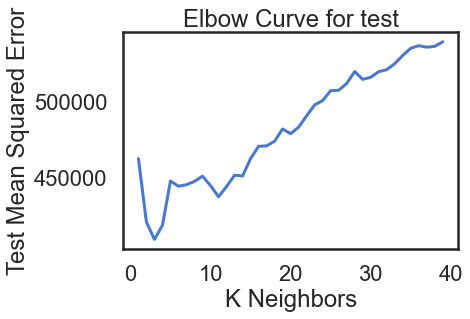

In [41]:
# plotting the Curves
plt.plot(k, test)
plt.xlabel('K Neighbors')
plt.ylabel('Test Mean Squared Error')
plt.title('Elbow Curve for test')

To identify the best number of clusters, we must choose the value of k at the "elbow," or the point at which the distortion/inertia begins to decrease linearly. As a result, we find that the best number of clusters for the given data is 10.


In [42]:
# Creating instance of KNN
reg = KNN(n_neighbors = 10)

# Fitting the model
reg.fit(train_x, train_y)

# Predicting over the Train Set and calculating MSE
train_predict = reg.predict(train_x)
test_predict = reg.predict(test_x)

# Print Scores for training. 

In [43]:
print('Mean Absolute Error:', metrics.mean_absolute_error(train_y,train_predict))
print('Mean Squared Error:', metrics.mean_squared_error(train_y,train_predict))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(train_y,train_predict)))
print('r2_score:', metrics.r2_score(train_y,train_predict))

Mean Absolute Error: 383.31385542168675
Mean Squared Error: 299800.2437951807
Root Mean Squared Error: 547.5401755078624
r2_score: 0.3635278925917371


# Print Scores for test. 

In [44]:
print('Mean Absolute Error:', metrics.mean_absolute_error(test_y,test_predict))
print('Mean Squared Error:', metrics.mean_squared_error(test_y,test_predict))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(test_y,test_predict)))
print('r2_score:', metrics.r2_score(test_y,test_predict))

Mean Absolute Error: 430.6963636363637
Mean Squared Error: 444573.5434545455
Root Mean Squared Error: 666.7634838940609
r2_score: 0.2693096091253049


# 2.Implementing Linear Regression

In [45]:
#importing Linear Regression and metric mean square error
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error as mae

In [46]:
# Creating instance of Linear Regresssion
lr = LinearRegression()

# Fitting the model
lr.fit(train_x, train_y)

LinearRegression()

# Cross Validation

In [47]:
# k-fold CV (using all variables)
lr_scores = cross_val_score(lr, train_x, train_y, scoring='r2', cv=5)
lr_scores     

array([0.21470715, 0.05279324, 0.09516094, 0.23166075, 0.44398609])

In [48]:
# Consistency using Mean and standard deviation in percentage
lr_scores.mean()*100, lr_scores.std()*100

(20.76616337577228, 13.646645893479374)

# Make predictions

In [49]:
# Predicting over the Train Set and calculating error
train_predict = lr.predict(train_x)
test_predict = lr.predict(test_x)

# Print Scores for training. 

In [50]:
print('Mean Absolute Error:', metrics.mean_absolute_error(train_y,train_predict))
print('Mean Squared Error:', metrics.mean_squared_error(train_y,train_predict))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(train_y,train_predict)))
print('r2_score:', metrics.r2_score(train_y,train_predict))

Mean Absolute Error: 419.1192494327975
Mean Squared Error: 319651.5929946447
Root Mean Squared Error: 565.3773898862995
r2_score: 0.32138373053257585


# Print Scores for test. 

In [51]:
from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(test_y,test_predict))
print('Mean Squared Error:', metrics.mean_squared_error(test_y,test_predict))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(test_y,test_predict)))
print('r2_score:', metrics.r2_score(test_y,test_predict))

Mean Absolute Error: 475.25404626914764
Mean Squared Error: 500419.2765350677
Root Mean Squared Error: 707.4031923415865
r2_score: 0.17752290446400332


# Parameters of Linear Regression

In [52]:
lr.coef_

array([   60.27655409,  1028.43819741,  -514.65245622,  1287.37302651,
       -1338.77914583,   177.14779641,   -73.45791181,   159.74174867])

Text(0.5, 1.0, 'Coefficient plot')

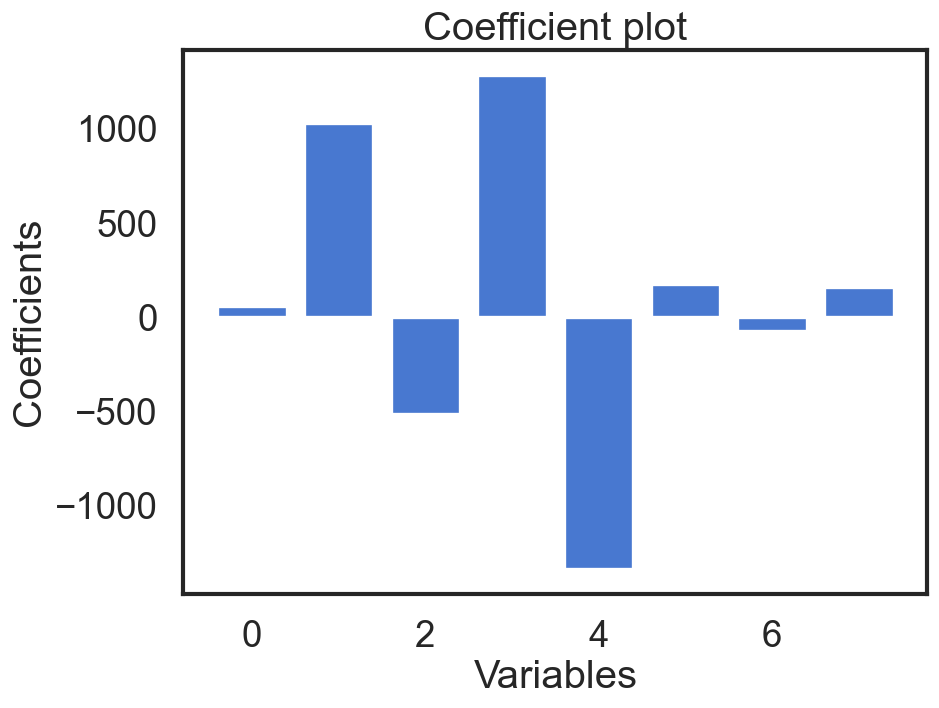

In [53]:
plt.figure(figsize=(8, 6), dpi=120, facecolor='w', edgecolor='b')
x = range(len(train_x.columns))
y = lr.coef_
plt.bar( x, y )
plt.xlabel( "Variables")
plt.ylabel('Coefficients')
plt.title('Coefficient plot')

We can see that the model is overly dependent on several independent variables, but these coefficients are unsuitable for interpretation because they are not scaled, thus we shall execute the interpretation.

# Checking assumptions of Linear Model

In [54]:
# Arranging and calculating the Residuals
residuals = pd.DataFrame({
    'fitted values' : test_y,
    'predicted values' : test_predict,
})

residuals['residuals'] = residuals['fitted values'] - residuals['predicted values']
residuals.head()

,fitted values,predicted values,residuals
38854,227,581.763478,-354.763478
528602,1985,1182.708135,802.291865
634782,654,574.878403,79.121597
571429,972,988.337662,-16.337662
717352,124,556.468511,-432.468511


# Checking Distribution of Residuals

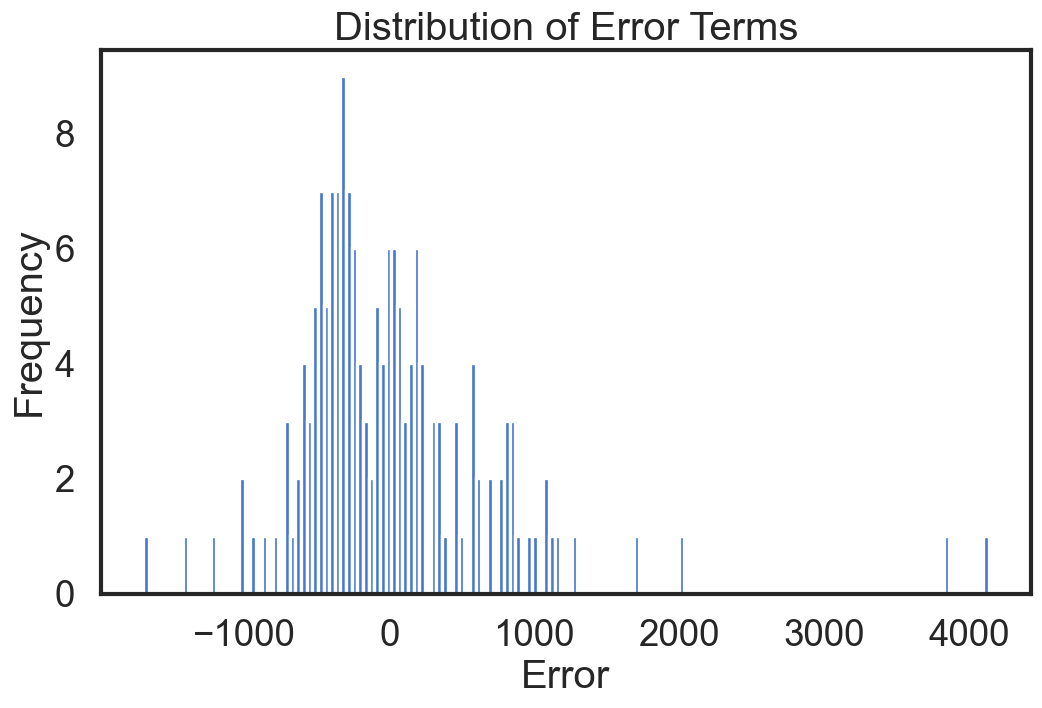

In [55]:
# Histogram for distribution
plt.figure(figsize=(10, 6), dpi=120, facecolor='w', edgecolor='b')
plt.hist(residuals.residuals, bins = 150)
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.title('Distribution of Error Terms')
plt.show()

According to the Histogram, the distribution of error is nearly normal, But there are some outliers on the Higher end of the errors.

# QQ-Plot (Is the data Normally Distributed?)

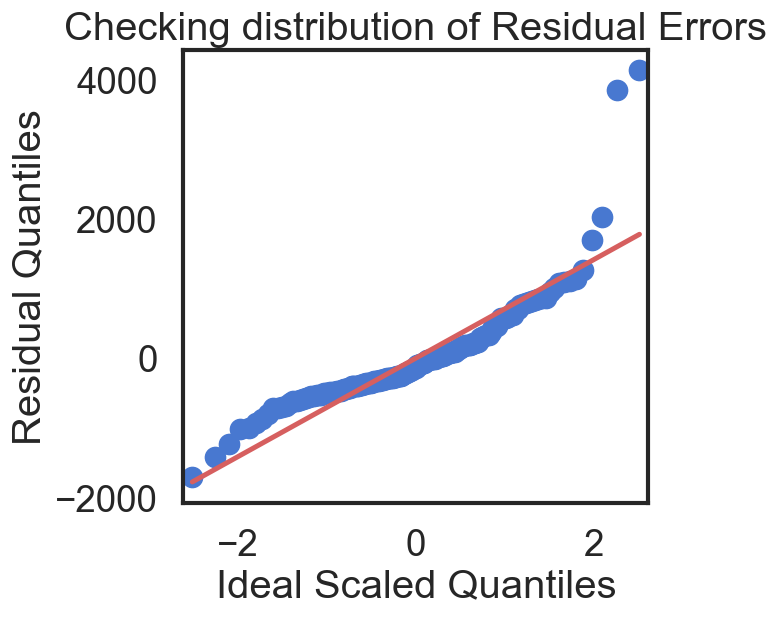

In [56]:
# importing the QQ-plot from the from the statsmodels
from statsmodels.graphics.gofplots import qqplot

## Plotting the QQ plot
fig, ax = plt.subplots(figsize=(5,5) , dpi = 120)
qqplot(residuals.residuals, line = 's' , ax = ax)
plt.ylabel('Residual Quantiles')
plt.xlabel('Ideal Scaled Quantiles')
plt.title('Checking distribution of Residual Errors')
plt.show()

The QQ-plot clearly validates our conclusions from the residuals histogram; the data is mainly normal, although there are several outliers on the higher end of the Residues.
The ACF plot plainly shows that there is almost no association between the error terms. As a result, there is no autocorrelation in the data.

# 3.Implimenting Decision Tree algorithm for regression

In [57]:
#Import Decision Tree Regressor and fit the model to the training data.
from sklearn.tree import DecisionTreeRegressor
tree = DecisionTreeRegressor()
tree.fit(train_x, train_y)

DecisionTreeRegressor()

# Cross Validation

In [58]:
# k-fold CV (using all variables)
dt_scores = cross_val_score(tree, train_x, train_y, scoring='r2', cv=5)
dt_scores     

array([0.24063539, 0.13079137, 0.14747811, 0.1425339 , 0.28187937])

In [59]:
# Consistency using Mean and standard deviation in percentage
dt_scores.mean()*100, dt_scores.std()*100

(18.86636281986277, 6.0932150941794205)

# Make predictions

In [60]:
#Make predictions and evaluate output.
train_predictions = tree.predict(train_x)
test_predictions = tree.predict(test_x)

# Print Scores for training. 

In [61]:
print('Mean Absolute Error:', metrics.mean_absolute_error(train_y,train_predictions))
print('Mean Squared Error:', metrics.mean_squared_error(train_y,train_predictions))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(train_y,train_predictions)))
print('r2_score:', metrics.r2_score(train_y,train_predictions))

Mean Absolute Error: 0.0
Mean Squared Error: 0.0
Root Mean Squared Error: 0.0
r2_score: 1.0


# Print Scores for test. 

In [62]:
print('Mean Absolute Error:', metrics.mean_absolute_error(test_y,test_predictions))
print('Mean Squared Error:', metrics.mean_squared_error(test_y,test_predictions))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(test_y,test_predictions)))
print('r2_score:', metrics.r2_score(test_y,test_predictions))

Mean Absolute Error: 492.0969696969697
Mean Squared Error: 514843.0424242424
Root Mean Squared Error: 717.525638861945
r2_score: 0.1538163495179964


R2 score is a statistic that indicates the performance of your model, rather than the absolute loss of how many wells your model performed.
As  MAE and MSE are context dependent, whereas the R2 score is context neutral.

In [63]:
results_df = pd.DataFrame({'KNN_Scores':knn_scores, 'LR_scores':lr_scores, 'DT_scores': dt_scores})
results_df

,KNN_Scores,LR_scores,DT_scores
0,0.096677,0.214707,0.240635
1,0.265154,0.052793,0.130791
2,0.125478,0.095161,0.147478
3,0.336476,0.231661,0.142534
4,0.210606,0.443986,0.281879


R squared gives a baseline model for comparing models that none of the other measures provide. In classification problems, we have something similar called a threshold, which is fixed at 0.5. R2 squared calculates how much better a regression line is than a mean line.

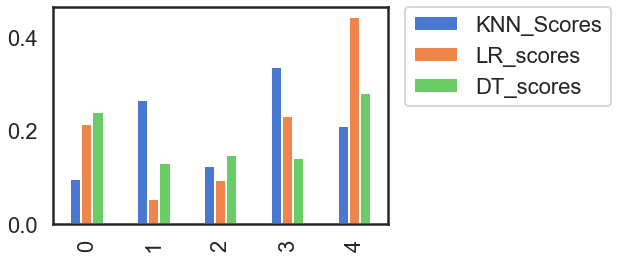

In [64]:
results_df.plot(y=['KNN_Scores',"LR_scores", "DT_scores"], kind="bar", legend=False)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

### Conclusions
1. The majority of rides follow a rather smooth distribution that looks almost log-normal with a peak just around exp(6.5)  i.e. about 17 minutes.
2. There are several suspiciously short rides with less than 10 seconds duration.
3. As discussed earlier, there are a few huge outliers near 12.
4. Most of the trips involve only 1 passenger. There are trips with 7-9 passengers but they are very low in number.
5. Vendor 2 has more number of trips as compared to vendor 1
6. Number of pickups for weekends is much lower than week days with a peak on Thursday (4). Note that here weekday is a decimal number, where 0 is Sunday and 6 is Saturday.
7. Number of pickups as expected is highest in late evenings. However, it is much lower during the morning peak hours.
8. We see that most trips are concentrated between these lat long only with a few significant clusters. These clusters are represented by the numerous peaks in the lattitude and longitude histograms
9. Trip durations are definitely shorter for late night and early morning hours that can be attributed to low traffic density
10. It follows a similar pattern when compared to number of pickups indicating a correlation between number of pickups and trip duration
11. Median trip duration does not vary much as can be seen from the above plot for different vendors.
12. The boxplot clearly shows that there not much of a difference in distribution for the most frequently occuring passenger count values - 1, 2, 3.
13. Another key observation is that the number of outliers are reduced for higher passenger counts but that only comes down to the individual frequencies of each passenger count.
14. From the correlation heatmap we see that the lattitude and longitude features have higher correlation with the target as compared to the other features.